# Regularization Models
#### Dataset Information:
Number of Features: 11  
Number of Instances: 4492 (1-minute interval)  

### Table of Contents<a name='table of contents'></a>

1. [Data Ingestion](#data ingestion)
2. [Features & Target Arrays](#features and target arrays)
3. [Ridge Regression](#ridge)  
    a. [Residuals Plot](#residuals plot)  
    b. [Prediction Error Plot](#prediction error plot)  
4. [RidgeCV](#ridgecv)  
    a. [Residuals Plot](#updated residuals plot)  
    b. [Prediction Error Plot](#updated prediction error plot)  
5. [LASSO](#lasso)
6. [ElasticNet](#elasticnet) 
7. [Save Model](#pickle)

In [1]:
%matplotlib inline

import os
import json
import time
import pickle
import requests
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import yellowbrick as yb
sns.set_palette('RdBu', 10)

## Data Ingestion<a name='data ingestion'></a>

In [2]:
URL = 'https://raw.githubusercontent.com/georgetown-analytics/classroom-occupancy/master/models/sensor_data_ml.csv'

def fetch_data(fname='sensor_data_ml.csv'):
    response = requests.get(URL)
    outpath  = os.path.abspath(fname)
    with open(outpath, 'wb') as f:
        f.write(response.content)
    
    return outpath

# Defining fetching data from the URL
DATA = fetch_data()

In [3]:
# Import sensor data
df = pd.read_csv('sensor_data_ml.csv', index_col='datetime', parse_dates=True)

# Rename columns
df.columns = ['temp', 'humidity', 'co2', 'light', 'light_st',
              'noise', 'bluetooth', 'images', 'door', 'occupancy_count', 'occupancy_level']

In [4]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4492 entries, 2017-03-25 09:05:00 to 2017-06-10 16:47:00
Data columns (total 11 columns):
temp               4492 non-null float64
humidity           4492 non-null float64
co2                4492 non-null float64
light              4492 non-null float64
light_st           4492 non-null float64
noise              4492 non-null float64
bluetooth          4492 non-null float64
images             4492 non-null float64
door               4492 non-null float64
occupancy_count    4492 non-null float64
occupancy_level    4492 non-null object
dtypes: float64(10), object(1)
memory usage: 421.1+ KB


,temp,humidity,co2,light,light_st,noise,bluetooth,images,door,occupancy_count,occupancy_level
datetime,,,,,,,,,,,
2017-03-25 09:05:00,22.600000,36.900000,781.000000,430.000000,1.0,511.000000,1.000000,15.242697,0.000000,0.000000,empty
2017-03-25 09:06:00,23.800000,38.954167,765.465279,428.533744,1.0,503.515931,11.399457,15.242697,0.000000,0.000000,empty
2017-03-25 09:07:00,23.850000,38.900000,768.458333,423.576500,1.0,510.548913,19.916667,15.242697,0.083333,4.416667,low
2017-03-25 09:08:00,23.900000,38.766667,777.791667,423.053571,1.0,506.504630,29.750000,15.242697,0.000000,23.416667,mid-level
2017-03-25 09:09:00,23.908333,38.733333,770.864583,438.607904,1.0,500.092672,35.860577,15.242697,0.000000,30.000000,high


## Features & Target Arrays<a name='features and target arrays'></a>

In [5]:
# Drop 'occupancy_level' column
df.drop('occupancy_level', axis=1, inplace=True)

In [6]:
# Create feature and target arrays
X = df.drop('occupancy_count', axis=1).values
y = df['occupancy_count']

In [7]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=12)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

## Ridge Regression<a name='ridge'></a>

In [8]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as mse, r2_score

# Create a ridge regression object: ridge
ridge = Ridge().fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = ridge.predict(X_test)

print('Ridge Model')
print('Root Mean Squared Error: {:.3f}'.format(np.sqrt(mse(y_test, y_pred))))
print('Mean Squared Error: {:.3f}'.format(mse(y_test, y_pred)))
print('Coefficient of Determination: {:.3f}'.format(r2_score(y_test, y_pred)))

Ridge Model
Root Mean Squared Error: 9.718
Mean Squared Error: 94.431
Coefficient of Determination: 0.230


In [9]:
print('ridge.coef_: {}'.format(ridge.coef_))
print('ridge.intercept_: {:.3f}'.format(ridge.intercept_))

ridge.coef_: [ -2.92272901e+00   5.62272714e-01   5.75341006e-02  -7.84558765e-03
  -1.93717018e+01   6.02406008e-02  -1.67847470e-02  -7.53378665e-02
  -6.34686056e-01]
ridge.intercept_: 6.678


In [10]:
from sklearn.model_selection import cross_val_score

# Compute 12-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(ridge, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')

# Print ridge mean absolute error
print('Mean Absolute Error: {:.4f}'.format(np.mean(cv_scores)))
print('Training set score: {:.3f}'.format(ridge.score(X_train, y_train)))
print('Test set score: {:.3f}'.format(ridge.score(X_test, y_test)))

Mean Absolute Error: -250.9242
Training set score: 0.400
Test set score: 0.230


#### Residuals Plot <a name='residuals plot'></a>

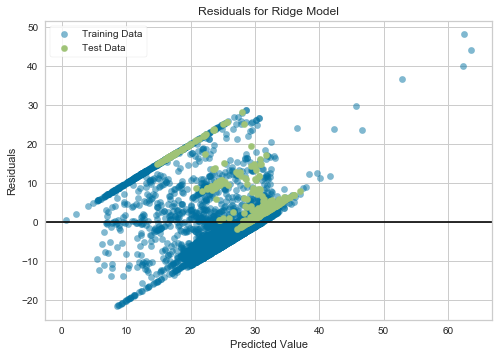

In [11]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(ridge)

fig = plt.figure()
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof() 
fig.savefig('ml_graphs/ridge_residuals_plot.png')

#### Prediction Error Plot <a name='prediction error plot'></a>

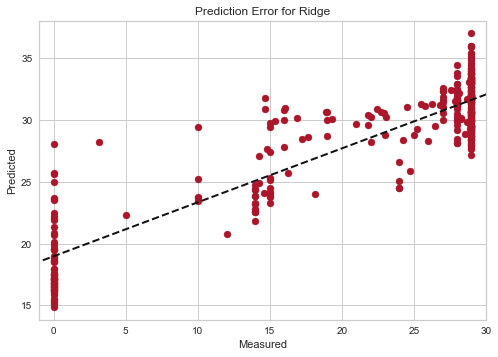

In [12]:
from yellowbrick.regressor import PredictionError

visualizer = PredictionError(ridge)

fig = plt.figure()
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof()
fig.savefig('ml_graphs/ridge_prediction_error.png')

### Ridge Hyperparameter Tuning<a name='ridgecv'></a>

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Setup the pipeline with StandardScaler: steps
steps = [('scaler', StandardScaler()),
         ('ridge', Ridge())]

# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Fit the pipeline to the training set: logreg_scaled
ridge_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a Logistic Regression classifier to the unscaled data: logreg_unscaled
ridge_unscaled = Ridge().fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {:.4f}'.format(ridge_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {:.4f}'.format(ridge_unscaled.score(X_test, y_test)))

Accuracy with Scaling: 0.2310
Accuracy without Scaling: 0.2302


In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

pipe = make_pipeline(StandardScaler(),
                     PolynomialFeatures(),
                     Ridge())

param_grid = {'polynomialfeatures__degree': [0, 1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=tscv, n_jobs=-1)

ridgecv = grid.fit(X_train, y_train)

In [17]:
ridgecv

GridSearchCV(cv=TimeSeriesSplit(n_splits=12), error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100], 'polynomialfeatures__degree': [0, 1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [18]:
print('Best score: {:.4f}'.format(ridgecv.best_score_))
print('Best parameters: {}'.format(ridgecv.best_params_))

Best score: -0.0571
Best parameters: {'ridge__alpha': 0.001, 'polynomialfeatures__degree': 0}


In [19]:
y_pred = ridgecv.predict(X_test)

print('Ridge Model')
print('Root Mean Squared Error: {:.3f}'.format(np.sqrt(mse(y_test, y_pred))))
print('Mean Squared Error: {:.3f}'.format(mse(y_test, y_pred)))
print('Coefficent of Determination: {:.3f}'.format(r2_score(y_test, y_pred)))

Ridge Model
Root Mean Squared Error: 11.478
Mean Squared Error: 131.746
Coefficent of Determination: -0.074


In [20]:
# Compute 12-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(ridgecv, X, y, cv=tscv, scoring='neg_mean_squared_error')

# Print mean absolute error score
print('Mean Absolute Error: {:.4f}'.format(np.mean(cv_scores)))

Mean Absolute Error: -138.6196


## Save Model<a name='pickle'></a>

In [19]:
import pickle

ridge_model = 'ridge_regression_model.sav'

# Save fitted model to disk
pickle.dump(ridgecv, open(ridge_model, 'wb'))

## LASSO<a name='lasso'></a>

In [22]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error as mse, r2_score

# Create a ridge regression object: ridge
lasso = Lasso().fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = lasso.predict(X_test)

print('LASSO Model')
print('Root Mean Squared Error: {:.3f}'.format(np.sqrt(mse(y_test, y_pred))))
print('Mean Squared Error: {:.3f}'.format(mse(y_test, y_pred)))
print('Coefficient of Determination: {:.3f}'.format(r2_score(y_test, y_pred)))

LASSO Model
Root Mean Squared Error: 10.371
Mean Squared Error: 107.555
Coefficient of Determination: 0.123


## ElasticNet<a name='elasticnet'></a>

In [25]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error as mse, r2_score

# Create a ridge regression object: ridge
elastic = ElasticNet().fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = elastic.predict(X_test)

print('ElasticNet Model')
print('Root Mean Squared Error: {:.3f}'.format(np.sqrt(mse(y_test, y_pred))))
print('Mean Squared Error: {:.3f}'.format(mse(y_test, y_pred)))
print('Coefficient of Determination: {:.3f}'.format(r2_score(y_test, y_pred)))

ElasticNet Model
Root Mean Squared Error: 10.439
Mean Squared Error: 108.970
Coefficient of Determination: 0.112


### [Return to Table of Contents](#table of contents)